In this notebook we will try figuring out all the RAW possible ways to train and optimize training a decode model as taught by Andrej Karpathy
Key Steps Explained:
- Basic Settings: Set the learning rate, device, random seeds, and batch sizes.
- Learning Rate Schedule Function: Define a function to adjust the learning rate using warmup and cosine decay.
- Optimizer Configuration: Create an optimizer and parameter groups for weight decay.
- Data Loading: Read and tokenize data from a file, and set up a data loader.
- Mixed Precision Training: Use autocast and GradScaler to speed up training and reduce memory usage.
- Model Initialization: Initialize the GPT model and compile it if supported.
- Training Loop: Iterate over the data, accumulate gradients, adjust learning rates, and update weights.

In [1]:
%autosave 300
%reload_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

Autosaving every 300 seconds


In [2]:
import os

os.chdir(
    "/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run2/code/Users/soutrik.chowdhury/EraV2_Transformers"
)
print(os.getcwd())

/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run2/code/Users/soutrik.chowdhury/EraV2_Transformers


In [39]:
import tiktoken
import torch
from notebooks.gpt2_models.dummy_model import GPT, GPTConfig
from torch.nn import functional as F
import time
from contextlib import nullcontext
import inspect
import numpy as np
import matplotlib.pyplot as plt
import math


#### Model Init using Pretrained weights for GPT-2 from HF
Initiate the model with pretrained weights from HF for Gpt2 and try creating 5 predicted sequences using same instruction prompts

In [4]:
num_return_sequences = 5  # Number of sentences to generate
max_length = 30  # Maximum length of the sentence

In [5]:
pretrained_model = GPT.from_pretrained("gpt2")
print(pretrained_model)

loading weights from pretrained gpt: gpt2


GPT(
  (transformer): ModuleDict(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (h): ModuleList(
      (0-11): 12 x Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=768, out_features=2304, bias=True)
          (c_proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (c_fc): Linear(in_features=768, out_features=3072, bias=True)
          (gelu): GELU(approximate='tanh')
          (c_proj): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)


What do we have - First and embedding layer with vocab size of 50257 and embedding size of 768. Post which we have pos embedding of 1024 block size .Then we have 12 transformer decoder layers with 12 heads each. Each decoder layer is build up with LayerNorm -> MultiHeadAttention -> LayerNorm -> FeedForward -> LayerNorm. The output of the last decoder layer is passed through a linear layer to get the logits for the next token prediction.

In [6]:
# basic settings
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
torch.cuda.manual_seed(42)
device_type = "cuda" if torch.cuda.is_available() else "cpu"

In [7]:
pretrained_model.to(device)
pretrained_model.eval()

GPT(
  (transformer): ModuleDict(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (h): ModuleList(
      (0-11): 12 x Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=768, out_features=2304, bias=True)
          (c_proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (c_fc): Linear(in_features=768, out_features=3072, bias=True)
          (gelu): GELU(approximate='tanh')
          (c_proj): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [8]:
dummy_str = "Hello I am a language Model, I am here to help you."
encoder = tiktoken.get_encoding(encoding_name="gpt2")
tokens = encoder.encode(dummy_str)
tokens_vec = torch.tensor(tokens, dtype=torch.long)
print(tokens_vec.shape)

torch.Size([14])


In [9]:
# creating a batch of repeated tokens
tokens_batch = tokens_vec.unsqueeze(0).repeat(num_return_sequences, 1)
tokens_batch = tokens_batch.to(device)
print(tokens_batch.shape)

torch.Size([5, 14])


In [10]:
def batch_prediction(xgen, model):

    xgen = xgen.clone()

    while xgen.size(1) < max_length:

        # forward the model to get the logits
        with torch.no_grad():
            logits, loss = model(xgen)  # (B, T, vocab_size)
            # take the logits at the last position
            logits = logits[:, -1, :]  # (B, vocab_size)
            # get the probabilities
            probs = F.softmax(logits, dim=-1)
            # do top-k sampling of 50 (huggingface pipeline default)
            # topk_probs here becomes (5, 50), topk_indices is (5, 50)
            topk_probs, topk_indices = torch.topk(probs, 50, dim=-1)
            # select a token from the top-k probabilities
            # note: multinomial does not demand the input to sum to 1
            ix = torch.multinomial(topk_probs, 1)  # (B, 1)
            # gather the corresponding indices
            xcol = torch.gather(topk_indices, -1, ix)  # (B, 1)
            # append to the sequence
            xgen = torch.cat((xgen, xcol), dim=1)

    return xgen

In [11]:
prediction_batch = batch_prediction(tokens_batch, pretrained_model)

In [12]:
print(prediction_batch.shape)

torch.Size([5, 30])


In [13]:
for i in range(prediction_batch.size(0)):
    x = prediction_batch[i, :max_length].tolist()
    decoded_str = encoder.decode(x)
    print(f">>{decoded_str}")
    print("\n")

>>Hello I am a language Model, I am here to help you. I am very happy with where this world would be if you could give me something


>>Hello I am a language Model, I am here to help you.

Thank you,

Emma<|endoftext|>Liz Peltz:


>>Hello I am a language Model, I am here to help you.

But as you say, my job now is to get things done.


>>Hello I am a language Model, I am here to help you.

I am a language model, I am here to help you. You


>>Hello I am a language Model, I am here to help you. If you have no idea what a data model is:

So. what




#### Basic Model Training of the model with toy data

Lets define the data loader for the model

In [14]:
encoder = tiktoken.get_encoding(encoding_name="gpt2")
filename = "./data/tinyshakespeare/input.txt"

In [15]:
def read_tokens(filename, encoder):
    with open(filename, "r") as file:
        lines = file.read()

    tokens = encoder.encode(lines)
    return tokens

In [16]:
class DataloaderLiter:
    def __init__(self, B, T, encoder, filename):
        self.B = B  # batch size
        self.T = T  # seq length
        tokens = read_tokens(filename, encoder)
        self.tokens = torch.tensor(tokens, dtype=torch.long)

        print(f"Total tokens in the file: {len(self.tokens)}")
        print(
            f"1 epoch will have {len(self.tokens) // (B * T)} iterations given Batch size={B} and Context length={T}"
        )

        self.current_position = 0
        self.num_iterations = len(self.tokens) // (B * T)

    def next_batch(self):
        B, T = self.B, self.T
        current_batch = self.tokens[
            self.current_position : self.current_position + (B * T) + 1
        ]  # +1 for the target
        x = current_batch[:-1].view(B, T)  # input tensor of shape (B, T)
        y = current_batch[1:].view(B, T)  # target tensor of shape (B, T)

        # updating the position for next batch
        self.current_position += B * T

        # we reset the position if the next batch is OOB
        if self.current_position + (B * T) + 1 > len(self.tokens):
            self.current_position = 0

        return x, y

First full training loop with the dummy model and the tinyshakespeare dataset 

In [77]:
train_loader = DataloaderLiter(B=8, T=1024, encoder=encoder, filename=filename)

Total tokens in the file: 338025
1 epoch will have 41 iterations given Batch size=8 and Context length=1024


In [18]:
num_epochs = 2
initial_iterations = 100
total_iteration = num_epochs * train_loader.num_iterations
print(f"Total iterations: {total_iteration}")

Total iterations: 82


In [19]:
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()
torch.cuda.synchronize()

In [20]:
transformer_model = GPT(GPTConfig())
transformer_model.to(device)

GPT(
  (transformer): ModuleDict(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (h): ModuleList(
      (0-11): 12 x Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=768, out_features=2304, bias=True)
          (c_proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (c_fc): Linear(in_features=768, out_features=3072, bias=True)
          (gelu): GELU(approximate='tanh')
          (c_proj): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [21]:
optimizer = torch.optim.Adam(transformer_model.parameters(), lr=3e-4)

In [22]:
transformer_model.train()
for iter in range(initial_iterations):
    start_time = time.time()
    x, y = train_loader.next_batch()
    x, y = x.to(device), y.to(device)
    optimizer.zero_grad()
    logits, loss = transformer_model(x, y)
    loss.backward()
    optimizer.step()
    end_time = time.time()
    torch.cuda.empty_cache()  # clear the cache
    torch.cuda.synchronize()  # wait for the computation to be done
    time_elapsed = (end_time - start_time) * 1000
    token_persec = x.numel() / time_elapsed
    print(
        f"for iter: {iter}, loss: {loss.item()}, time: {time_elapsed:.2f}ms, tokens/mssec: {token_persec:.2f}"
    )

for iter: 0, loss: 11.010125160217285, time: 801.24ms, tokens/mssec: 10.22
for iter: 1, loss: 9.59991455078125, time: 183.30ms, tokens/mssec: 44.69
for iter: 2, loss: 8.829021453857422, time: 253.47ms, tokens/mssec: 32.32
for iter: 3, loss: 8.613096237182617, time: 256.11ms, tokens/mssec: 31.99
for iter: 4, loss: 8.430353164672852, time: 246.82ms, tokens/mssec: 33.19
for iter: 5, loss: 8.372970581054688, time: 253.79ms, tokens/mssec: 32.28
for iter: 6, loss: 8.321300506591797, time: 248.37ms, tokens/mssec: 32.98
for iter: 7, loss: 7.983494281768799, time: 257.68ms, tokens/mssec: 31.79
for iter: 8, loss: 7.7129058837890625, time: 218.96ms, tokens/mssec: 37.41
for iter: 9, loss: 7.6699419021606445, time: 207.05ms, tokens/mssec: 39.57
for iter: 10, loss: 7.6337361335754395, time: 248.13ms, tokens/mssec: 33.02
for iter: 11, loss: 7.454716682434082, time: 210.50ms, tokens/mssec: 38.92
for iter: 12, loss: 7.3984174728393555, time: 244.49ms, tokens/mssec: 33.51
for iter: 13, loss: 7.170972824

#### Model Optimization and  Faster Training

Precision settings - Application of tf float32 to increase throughput

In [25]:
torch.backends.cuda.matmul.allow_tf32 = True  # allow tf32 on matmul
torch.backends.cudnn.allow_tf32 = True  # allow tf32 on cudnn
torch.backends.cudnn.benchmark = True  # set to true for faster training
torch.set_float32_matmul_precision("high")

In [26]:
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()
torch.cuda.synchronize()

In [27]:
transformer_model = GPT(GPTConfig())
transformer_model.to(device)

GPT(
  (transformer): ModuleDict(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (h): ModuleList(
      (0-11): 12 x Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=768, out_features=2304, bias=True)
          (c_proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (c_fc): Linear(in_features=768, out_features=3072, bias=True)
          (gelu): GELU(approximate='tanh')
          (c_proj): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [28]:
optimizer = torch.optim.Adam(transformer_model.parameters(), lr=3e-4)

In [29]:
transformer_model.train()
for iter in range(initial_iterations):
    start_time = time.time()
    x, y = train_loader.next_batch()
    x, y = x.to(device), y.to(device)
    optimizer.zero_grad()
    logits, loss = transformer_model(x, y)
    loss.backward()
    optimizer.step()
    end_time = time.time()
    torch.cuda.empty_cache()  # clear the cache
    torch.cuda.synchronize()  # wait for the computation to be done
    time_elapsed = (end_time - start_time) * 1000
    token_persec = x.numel() / time_elapsed
    print(
        f"for iter: {iter}, loss: {loss.item()}, time: {time_elapsed:.2f}ms, tokens/mssec: {token_persec:.2f}"
    )

for iter: 0, loss: 10.890664100646973, time: 42.46ms, tokens/mssec: 192.94
for iter: 1, loss: 9.615824699401855, time: 240.92ms, tokens/mssec: 34.00
for iter: 2, loss: 9.006220817565918, time: 268.63ms, tokens/mssec: 30.50
for iter: 3, loss: 8.814001083374023, time: 273.68ms, tokens/mssec: 29.93
for iter: 4, loss: 8.714908599853516, time: 271.72ms, tokens/mssec: 30.15
for iter: 5, loss: 8.374526977539062, time: 274.42ms, tokens/mssec: 29.85
for iter: 6, loss: 8.152328491210938, time: 278.57ms, tokens/mssec: 29.41
for iter: 7, loss: 7.994481563568115, time: 266.88ms, tokens/mssec: 30.70
for iter: 8, loss: 7.850434303283691, time: 257.98ms, tokens/mssec: 31.75
for iter: 9, loss: 7.57218074798584, time: 270.49ms, tokens/mssec: 30.29
for iter: 10, loss: 7.56642484664917, time: 272.42ms, tokens/mssec: 30.07
for iter: 11, loss: 7.270780086517334, time: 261.13ms, tokens/mssec: 31.37
for iter: 12, loss: 7.126434803009033, time: 281.27ms, tokens/mssec: 29.13
for iter: 13, loss: 6.97861480712890

Precision settings - Application of autocast and mixed precision training aslong with gradient scaling
* bfloat16 is only available on A series GPUs so we use float16 for mixed precision training along with gradient scaling
* always use autocast to reduce the precision of the model to float16 along with scaling the gradients to avoid underflow and overflow

In [24]:
dtype = (
    "bfloat16"
    if torch.cuda.is_available() and torch.cuda.is_bf16_supported()
    else "float16"
)
print(f"Using {dtype} for automatic mixed precision training")

# note: float16 data type will automatically use a GradScaler
ptdtype = {
    "float32": torch.float32,
    "bfloat16": torch.bfloat16,
    "float16": torch.float16,
}[dtype]

Using float16 for automatic mixed precision training


In [ ]:

# context manager for automatic mixed precision training
ctx = (
    nullcontext()
    if device_type == "cpu"
    else torch.amp.autocast(device_type=device_type, dtype=ptdtype)
)

if ctx != nullcontext():
    # GradScaler for automatic mixed precision training
    scaler = torch.cuda.amp.GradScaler(enabled=True)

In [38]:
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()
torch.cuda.synchronize()

In [39]:
transformer_model = GPT(GPTConfig())
transformer_model.to(device)

GPT(
  (transformer): ModuleDict(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (h): ModuleList(
      (0-11): 12 x Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=768, out_features=2304, bias=True)
          (c_proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (c_fc): Linear(in_features=768, out_features=3072, bias=True)
          (gelu): GELU(approximate='tanh')
          (c_proj): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [40]:
optimizer = torch.optim.Adam(transformer_model.parameters(), lr=3e-4)

In [41]:
transformer_model.train()
for iter in range(initial_iterations):
    start_time = time.time()
    x, y = train_loader.next_batch()
    x, y = x.to(device), y.to(device)
    optimizer.zero_grad()
    with ctx:
        logits, loss = transformer_model(x, y)

    # backward pass with GradScaler
    scaler.scale(loss).backward()
    # Unscales the gradients and calls optimizer.step()
    scaler.step(optimizer)
    # Updates the scale for next iteration
    scaler.update()
    end_time = time.time()
    torch.cuda.empty_cache()  # clear the cache
    torch.cuda.synchronize()  # wait for the computation to be done
    time_elapsed = (end_time - start_time) * 1000
    token_persec = x.numel() / time_elapsed
    print(
        f"for iter: {iter}, loss: {loss.item()}, time: {time_elapsed:.2f}ms, tokens/mssec: {token_persec:.2f}"
    )

for iter: 0, loss: 10.965310096740723, time: 390.68ms, tokens/mssec: 20.97
for iter: 1, loss: 9.53087329864502, time: 251.98ms, tokens/mssec: 32.51
for iter: 2, loss: 9.536520004272461, time: 295.73ms, tokens/mssec: 27.70
for iter: 3, loss: 8.736123085021973, time: 306.79ms, tokens/mssec: 26.70
for iter: 4, loss: 8.643856048583984, time: 298.67ms, tokens/mssec: 27.43
for iter: 5, loss: 8.479509353637695, time: 290.01ms, tokens/mssec: 28.25
for iter: 6, loss: 8.368569374084473, time: 304.90ms, tokens/mssec: 26.87
for iter: 7, loss: 7.94486665725708, time: 297.54ms, tokens/mssec: 27.53
for iter: 8, loss: 7.701452255249023, time: 271.95ms, tokens/mssec: 30.12
for iter: 9, loss: 7.574922561645508, time: 301.71ms, tokens/mssec: 27.15
for iter: 10, loss: 7.519839286804199, time: 297.82ms, tokens/mssec: 27.51
for iter: 11, loss: 7.5592041015625, time: 304.23ms, tokens/mssec: 26.93
for iter: 12, loss: 7.290929317474365, time: 293.78ms, tokens/mssec: 27.88
for iter: 13, loss: 7.059926986694336,

Gradient clipping - to prevent exploding gradients

In [43]:
grad_clip = 1.0

In [44]:
# context manager for automatic mixed precision training
ctx = (
    nullcontext()
    if device_type == "cpu"
    else torch.amp.autocast(device_type=device_type, dtype=ptdtype)
)

if ctx != nullcontext():
    # GradScaler for automatic mixed precision training
    scaler = torch.cuda.amp.GradScaler(enabled=True)

In [45]:
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()
torch.cuda.synchronize()

In [46]:
transformer_model = GPT(GPTConfig())
transformer_model.to(device)

GPT(
  (transformer): ModuleDict(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (h): ModuleList(
      (0-11): 12 x Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=768, out_features=2304, bias=True)
          (c_proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (c_fc): Linear(in_features=768, out_features=3072, bias=True)
          (gelu): GELU(approximate='tanh')
          (c_proj): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [48]:
optimizer = torch.optim.Adam(transformer_model.parameters(), lr=3e-4)

In [49]:
transformer_model.train()
for iter in range(initial_iterations):
    start_time = time.time()
    x, y = train_loader.next_batch()
    x, y = x.to(device), y.to(device)
    optimizer.zero_grad()
    with ctx:
        logits, loss = transformer_model(x, y)

    # backward pass with GradScaler
    scaler.scale(loss).backward()
    if grad_clip != 0.0:
        # unscales the gradients of optimizer's assigned params in-place
        scaler.unscale_(optimizer)
        # clip the gradients
        norm = torch.nn.utils.clip_grad_norm(transformer_model.parameters(), grad_clip)

    # Unscales the gradients and calls optimizer.step()
    scaler.step(optimizer)
    # Updates the scale for next iteration
    scaler.update()
    end_time = time.time()
    torch.cuda.empty_cache()  # clear the cache
    torch.cuda.synchronize()  # wait for the computation to be done
    time_elapsed = (end_time - start_time) * 1000
    token_persec = x.numel() / time_elapsed
    print(
        f"for iter: {iter}, loss: {loss.item()}, norm: {norm:.2f} time: {time_elapsed:.2f}ms, tokens/mssec: {token_persec:.2f}"
    )

<ipython-input-49-26765549d308>:16: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  norm = torch.nn.utils.clip_grad_norm(transformer_model.parameters(), grad_clip)


for iter: 0, loss: 10.942142486572266, norm: 28.75 time: 485.05ms, tokens/mssec: 16.89
for iter: 1, loss: 9.615848541259766, norm: 5.15 time: 269.93ms, tokens/mssec: 30.35
for iter: 2, loss: 9.241558074951172, norm: 7.01 time: 296.41ms, tokens/mssec: 27.64
for iter: 3, loss: 9.006820678710938, norm: 6.30 time: 289.35ms, tokens/mssec: 28.31
for iter: 4, loss: 8.795352935791016, norm: 2.83 time: 291.84ms, tokens/mssec: 28.07
for iter: 5, loss: 8.484068870544434, norm: 3.05 time: 298.64ms, tokens/mssec: 27.43
for iter: 6, loss: 8.187207221984863, norm: 2.49 time: 297.81ms, tokens/mssec: 27.51
for iter: 7, loss: 7.973771572113037, norm: 1.88 time: 297.58ms, tokens/mssec: 27.53
for iter: 8, loss: 7.765438556671143, norm: 1.77 time: 275.73ms, tokens/mssec: 29.71
for iter: 9, loss: 7.726118087768555, norm: 1.80 time: 294.66ms, tokens/mssec: 27.80
for iter: 10, loss: 7.417959213256836, norm: 1.59 time: 293.73ms, tokens/mssec: 27.89
for iter: 11, loss: 7.235445976257324, norm: 1.46 time: 292.80

Model Optimizations by GPT3 paper -I
* Use of 50304 as the vocab size as it is devised to be a multiple of 8
* use of specific version of Adam optimizer
* use of torch compile for faster training
* use of 2048 context size / sequence length for training

In [40]:
dtype = (
    "bfloat16"
    if torch.cuda.is_available() and torch.cuda.is_bf16_supported()
    else "float16"
)
print(f"Using {dtype} for automatic mixed precision training")

# note: float16 data type will automatically use a GradScaler
ptdtype = {
    "float32": torch.float32,
    "bfloat16": torch.bfloat16,
    "float16": torch.float16,
}[dtype]

Using float16 for automatic mixed precision training


In [41]:
# permisssion for grad_clip
grad_clip = 0.0

# model compilation
compile = True

# context manager for automatic mixed precision training
ctx = (
    nullcontext()
    if device_type == "cpu"
    else torch.amp.autocast(device_type=device_type, dtype=ptdtype)
)

if ctx != nullcontext():
    # GradScaler for automatic mixed precision training
    scaler = torch.cuda.amp.GradScaler(enabled=True)


torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()
torch.cuda.synchronize()

In [42]:
transformer_model = GPT(
    GPTConfig(
        vocab_size=50304,
        block_size=2048,
        n_layer=12,
        n_head=12,
        n_embd=768,
    )
)
transformer_model.to(device)

if compile:
    transformer_model = torch.compile(transformer_model)

# Adam optimizer
optimizer = torch.optim.Adam(
    transformer_model.parameters(), lr=3e-4, betas=(0.9, 0.95), eps=1e-8
)

In [43]:
train_loader = DataloaderLiter(B=8, T=1024, encoder=encoder, filename=filename)

Total tokens in the file: 338025
1 epoch will have 41 iterations


In [44]:
num_epochs = 2
initial_iterations = 100
total_iteration = num_epochs * train_loader.num_iterations
print(f"Total iterations: {total_iteration}")

Total iterations: 82


In [45]:
transformer_model.train()
for iter in range(total_iteration):
    start_time = time.time()
    x, y = train_loader.next_batch()
    x, y = x.to(device), y.to(device)
    optimizer.zero_grad()
    with ctx:
        logits, loss = transformer_model(x, y)

    # backward pass with GradScaler
    scaler.scale(loss).backward()
    norm = 0.0
    if grad_clip != 0.0:
        # unscales the gradients of optimizer's assigned params in-place
        scaler.unscale_(optimizer)
        # clip the gradients
        norm = torch.nn.utils.clip_grad_norm(transformer_model.parameters(), grad_clip)

    # Unscales the gradients and calls optimizer.step()
    scaler.step(optimizer)
    # Updates the scale for next iteration
    scaler.update()
    end_time = time.time()
    torch.cuda.empty_cache()  # clear the cache
    torch.cuda.synchronize()  # wait for the computation to be done
    time_elapsed = (end_time - start_time) * 1000
    token_persec = x.numel() / time_elapsed
    print(
        f"for iter: {iter}, loss: {loss.item()}, norm: {norm:.2f} time: {time_elapsed:.2f}ms, tokens/mssec: {token_persec:.2f}"
    )

for iter: 0, loss: 10.936626434326172, norm: 0.00 time: 43660.35ms, tokens/mssec: 0.19
for iter: 1, loss: 9.465581893920898, norm: 0.00 time: 238.07ms, tokens/mssec: 34.41
for iter: 2, loss: 8.741138458251953, norm: 0.00 time: 232.24ms, tokens/mssec: 35.27
for iter: 3, loss: 8.591870307922363, norm: 0.00 time: 242.22ms, tokens/mssec: 33.82
for iter: 4, loss: 8.394872665405273, norm: 0.00 time: 241.84ms, tokens/mssec: 33.87
for iter: 5, loss: 8.374696731567383, norm: 0.00 time: 237.87ms, tokens/mssec: 34.44
for iter: 6, loss: 8.338766098022461, norm: 0.00 time: 231.76ms, tokens/mssec: 35.35
for iter: 7, loss: 8.015644073486328, norm: 0.00 time: 248.27ms, tokens/mssec: 33.00
for iter: 8, loss: 7.703030586242676, norm: 0.00 time: 230.76ms, tokens/mssec: 35.50
for iter: 9, loss: 7.702876091003418, norm: 0.00 time: 238.97ms, tokens/mssec: 34.28
for iter: 10, loss: 7.702516555786133, norm: 0.00 time: 235.65ms, tokens/mssec: 34.76
for iter: 11, loss: 7.5014142990112305, norm: 0.00 time: 242.9

We fail in increasing the context size due to memory issue in the GPU. We will try to use the gradien accumulation to solve this issue.

Model Optimizations by GPT3 paper -II
* Tweaking the learning rate for optimizer using cosine decay with initial warmup
* Application of gradient accumulation to increase the batch size without increasing the memory usage
*  Optimized Adam W optimizer with added flexibility

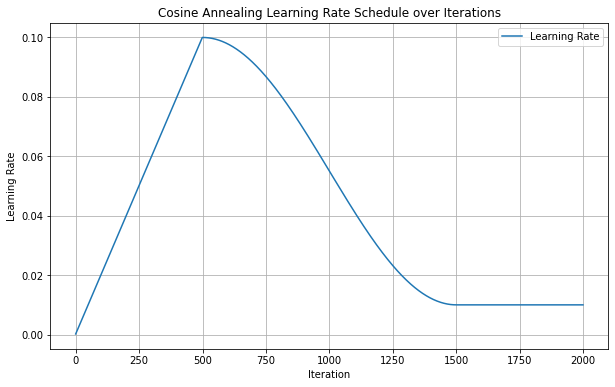

In [17]:

# Define the get_lr function
def get_lr(it, warmup_iters=500, learning_rate=0.1, lr_decay_iters=1500, min_lr=0.01):
    if it < warmup_iters:
        return learning_rate * (it + 1) / warmup_iters
    if it > lr_decay_iters:
        return min_lr

    # Cosine annealing learning rate schedule
    decay_ratio = (it - warmup_iters) / (lr_decay_iters - warmup_iters)
    assert 0 <= decay_ratio <= 1
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio))
    return min_lr + coeff * (learning_rate - min_lr)


In [ ]:

# Generate the learning rate values for 2000 iterations
iterations = np.arange(2000)
learning_rates = [get_lr(it) for it in iterations]

# Plot the learning rate schedule
plt.figure(figsize=(10, 6))
plt.plot(iterations, learning_rates, label="Learning Rate")
plt.xlabel("Iteration")
plt.ylabel("Learning Rate")
plt.title("Cosine Annealing Learning Rate Schedule over Iterations")
plt.legend()
plt.grid(True)
plt.show()

Here's the graph of the learning rate schedule over 2000 iterations:

* Linear Warmup Phase: From iteration 0 to 500, the learning rate increases linearly from 0 to 0.1.
* Cosine Decay Phase: From iteration 500 to 1500, the learning rate decreases following a cosine curve down to 0.01.
* Constant Minimum Learning Rate: After iteration 1500, the learning rate remains constant at 0.01.

LR scheduler

In [18]:
max_lr = 6e-4
min_lr = max_lr * 0.3
warmup_steps = 10

In [19]:
# this should be run first
dtype = (
    "bfloat16"
    if torch.cuda.is_available() and torch.cuda.is_bf16_supported()
    else "float16"
)
print(f"Using {dtype} for automatic mixed precision training")

# note: float16 data type will automatically use a GradScaler
ptdtype = {
    "float32": torch.float32,
    "bfloat16": torch.bfloat16,
    "float16": torch.float16,
}[dtype]

Using float16 for automatic mixed precision training


In [20]:
# permisssion for grad_clip
grad_clip = 0.0

# model compilation
compile = True

# context manager for automatic mixed precision training
ctx = (
    nullcontext()
    if device_type == "cpu"
    else torch.amp.autocast(device_type=device_type, dtype=ptdtype)
)

if ctx != nullcontext():
    # GradScaler for automatic mixed precision training
    scaler = torch.cuda.amp.GradScaler(enabled=True)


torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()
torch.cuda.synchronize()

In [21]:
transformer_model = GPT(
    GPTConfig(
        vocab_size=50304,
        block_size=2048,
        n_layer=12,
        n_head=12,
        n_embd=768,
    )
)
transformer_model.to(device)

if compile:
    transformer_model = torch.compile(transformer_model)

# change the optimizer to AdamW
optimizer = torch.optim.AdamW(
    transformer_model.parameters(), lr=3e-4, betas=(0.9, 0.95), eps=1e-8
)

/anaconda/envs/torch_env/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [22]:
train_loader = DataloaderLiter(B=8, T=1024, encoder=encoder, filename=filename)

Total tokens in the file: 338025
1 epoch will have 41 iterations given Batch size=8 and Context length=1024


In [23]:
num_epochs = 2
initial_iterations = 100
total_iteration = num_epochs * train_loader.num_iterations
print(f"Total iterations: {total_iteration}")

Total iterations: 82


In [24]:
transformer_model.train()
for iter in range(total_iteration):
    start_time = time.time()
    x, y = train_loader.next_batch()
    x, y = x.to(device), y.to(device)
    optimizer.zero_grad()
    with ctx:
        logits, loss = transformer_model(x, y)

    # backward pass with GradScaler
    scaler.scale(loss).backward()
    norm = 0.0
    if grad_clip != 0.0:
        # unscales the gradients of optimizer's assigned params in-place
        scaler.unscale_(optimizer)
        # clip the gradients
        norm = torch.nn.utils.clip_grad_norm(transformer_model.parameters(), grad_clip)

    # get the current learning rate
    lr = get_lr(iter, warmup_steps, max_lr, int(total_iteration * 0.8), min_lr)
    # update the learning rate
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

    # Unscales the gradients and calls optimizer.step()
    scaler.step(optimizer)
    # Updates the scale for next iteration
    scaler.update()
    end_time = time.time()
    torch.cuda.empty_cache()  # clear the cache
    torch.cuda.synchronize()  # wait for the computation to be done
    time_elapsed = (end_time - start_time) * 1000
    token_persec = x.numel() / time_elapsed
    print(
        f"for iter: {iter} | loss: {loss.item()} | norm: {norm:.2f} | lr {lr:.4e} | time: {time_elapsed:.2f}ms | tokens/mssec: {token_persec:.2f}"
    )

for iter: 0 | loss: 10.953805923461914 | norm: 0.00 | lr 6.0000e-05 | time: 30262.87ms | tokens/mssec: 0.27
for iter: 1 | loss: 9.560873031616211 | norm: 0.00 | lr 1.2000e-04 | time: 155.52ms | tokens/mssec: 52.68
for iter: 2 | loss: 9.007200241088867 | norm: 0.00 | lr 1.8000e-04 | time: 209.07ms | tokens/mssec: 39.18
for iter: 3 | loss: 9.17491340637207 | norm: 0.00 | lr 2.4000e-04 | time: 176.58ms | tokens/mssec: 46.39
for iter: 4 | loss: 8.8216552734375 | norm: 0.00 | lr 3.0000e-04 | time: 157.58ms | tokens/mssec: 51.99
for iter: 5 | loss: 8.841644287109375 | norm: 0.00 | lr 3.6000e-04 | time: 156.14ms | tokens/mssec: 52.47
for iter: 6 | loss: 8.685921669006348 | norm: 0.00 | lr 4.2000e-04 | time: 157.29ms | tokens/mssec: 52.08
for iter: 7 | loss: 8.220111846923828 | norm: 0.00 | lr 4.8000e-04 | time: 157.20ms | tokens/mssec: 52.11
for iter: 8 | loss: 7.750452995300293 | norm: 0.00 | lr 5.4000e-04 | time: 158.24ms | tokens/mssec: 51.77
for iter: 9 | loss: 7.584262847900391 | norm: 0

ADAMW optimizer with weight decay

In [26]:
def configure_optimizers(model, weight_decay, learning_rate, device_type):
    """Create the optimizer and scheduler for training"""

    # start with all of the candidate parameters (that require grad)
    param_dict = {pn: p for pn, p in model.named_parameters()}
    param_dict = {pn: p for pn, p in param_dict.items() if p.requires_grad}

    # create optim groups. Any parameters that is 2D will be weight decayed, otherwise no.
    # i.e. all weight tensors in matmuls + embeddings decay, all biases and layernorms don't.
    decay_params = [p for n, p in param_dict.items() if p.dim() >= 2]
    nodecay_params = [p for n, p in param_dict.items() if p.dim() < 2]
    optim_groups = [
        {"params": decay_params, "weight_decay": weight_decay},
        {"params": nodecay_params, "weight_decay": 0.0},
    ]

    num_decay_params = sum(p.numel() for p in decay_params)
    num_nodecay_params = sum(p.numel() for p in nodecay_params)

    print(
        f"num decayed parameter tensors: {len(decay_params)}, with {num_decay_params:,} parameters"
    )
    # Create AdamW optimizer and use the fused version if it is available
    fused_available = "fused" in inspect.signature(torch.optim.AdamW).parameters
    use_fused = fused_available and device_type == "cuda"

    optimizer = torch.optim.AdamW(
        optim_groups, lr=learning_rate, betas=(0.9, 0.95), eps=1e-8, fused=use_fused
    )
    return optimizer

In [27]:
# permisssion for grad_clip
grad_clip = 0.0

# model compilation
compile = True

# context manager for automatic mixed precision training
ctx = (
    nullcontext()
    if device_type == "cpu"
    else torch.amp.autocast(device_type=device_type, dtype=ptdtype)
)

if ctx != nullcontext():
    # GradScaler for automatic mixed precision training
    scaler = torch.cuda.amp.GradScaler(enabled=True)


torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()
torch.cuda.synchronize()

In [28]:
transformer_model = GPT(
    GPTConfig(
        vocab_size=50304,
        block_size=2048,
        n_layer=12,
        n_head=12,
        n_embd=768,
    )
)
transformer_model.to(device)

if compile:
    transformer_model = torch.compile(transformer_model)

In [29]:
optimizer = configure_optimizers(transformer_model, 0.1, max_lr, device_type)

num decayed parameter tensors: 50, with 125,140,992 parameters


In [30]:
train_loader = DataloaderLiter(B=8, T=1024, encoder=encoder, filename=filename)

Total tokens in the file: 338025
1 epoch will have 41 iterations given Batch size=8 and Context length=1024


In [31]:
num_epochs = 2
initial_iterations = 100
total_iteration = num_epochs * train_loader.num_iterations
print(f"Total iterations: {total_iteration}")

Total iterations: 82


In [32]:
transformer_model.train()
for iter in range(total_iteration):
    start_time = time.time()
    x, y = train_loader.next_batch()
    x, y = x.to(device), y.to(device)
    optimizer.zero_grad()
    with ctx:
        logits, loss = transformer_model(x, y)

    # backward pass with GradScaler
    scaler.scale(loss).backward()
    norm = 0.0
    if grad_clip != 0.0:
        # unscales the gradients of optimizer's assigned params in-place
        scaler.unscale_(optimizer)
        # clip the gradients
        norm = torch.nn.utils.clip_grad_norm(transformer_model.parameters(), grad_clip)

    # get the current learning rate
    lr = get_lr(iter, warmup_steps, max_lr, int(total_iteration * 0.8), min_lr)
    # update the learning rate
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

    # Unscales the gradients and calls optimizer.step()
    scaler.step(optimizer)
    # Updates the scale for next iteration
    scaler.update()
    end_time = time.time()
    torch.cuda.empty_cache()  # clear the cache
    torch.cuda.synchronize()  # wait for the computation to be done
    time_elapsed = (end_time - start_time) * 1000
    token_persec = x.numel() / time_elapsed
    print(
        f"for iter: {iter} | loss: {loss.item()} | norm: {norm:.2f} | lr {lr:.4e} | time: {time_elapsed:.2f}ms | tokens/mssec: {token_persec:.2f}"
    )

for iter: 0 | loss: 10.970207214355469 | norm: 0.00 | lr 6.0000e-05 | time: 23852.85ms | tokens/mssec: 0.34
for iter: 1 | loss: 9.622097969055176 | norm: 0.00 | lr 1.2000e-04 | time: 34.38ms | tokens/mssec: 238.29
for iter: 2 | loss: 9.034076690673828 | norm: 0.00 | lr 1.8000e-04 | time: 90.47ms | tokens/mssec: 90.55
for iter: 3 | loss: 9.174388885498047 | norm: 0.00 | lr 2.4000e-04 | time: 86.06ms | tokens/mssec: 95.19
for iter: 4 | loss: 8.857473373413086 | norm: 0.00 | lr 3.0000e-04 | time: 163.88ms | tokens/mssec: 49.99
for iter: 5 | loss: 8.646048545837402 | norm: 0.00 | lr 3.6000e-04 | time: 66.54ms | tokens/mssec: 123.11
for iter: 6 | loss: 8.544068336486816 | norm: 0.00 | lr 4.2000e-04 | time: 95.97ms | tokens/mssec: 85.36
for iter: 7 | loss: 8.18879508972168 | norm: 0.00 | lr 4.8000e-04 | time: 65.38ms | tokens/mssec: 125.31
for iter: 8 | loss: 7.78149938583374 | norm: 0.00 | lr 5.4000e-04 | time: 91.21ms | tokens/mssec: 89.82
for iter: 9 | loss: 7.609959602355957 | norm: 0.00

Grad Accummulation: To use larger batch sizes, we can accumulate gradients over multiple iterations before updating the model parameters. This is useful when the model is too large to fit in the memory or when the batch size is too small to get a good gradient estimate.

In [47]:
ideal_batch_size = 524288  # as per GPT3 paper
permit_batch = 8
permit_context = 1024

# grad_accumulation_steps = ideal_batch_size // (permit_batch * permit_context)
grad_accumulation_steps = ideal_batch_size // (permit_batch * permit_context)
print(f"grad_accumulation_steps: {grad_accumulation_steps}")

grad_accumulation_steps: 64


In [48]:
# permisssion for grad_clip
grad_clip = 0.0

# model compilation
compile = True

# context manager for automatic mixed precision training
ctx = (
    nullcontext()
    if device_type == "cpu"
    else torch.amp.autocast(device_type=device_type, dtype=ptdtype)
)

if ctx != nullcontext():
    # GradScaler for automatic mixed precision training
    scaler = torch.cuda.amp.GradScaler(enabled=True)


torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()
torch.cuda.synchronize()

In [49]:
transformer_model = GPT(
    GPTConfig(
        vocab_size=50304,
        block_size=2048,
        n_layer=12,
        n_head=12,
        n_embd=768,
    )
)
transformer_model.to(device)

if compile:
    transformer_model = torch.compile(transformer_model)

In [50]:
optimizer = configure_optimizers(transformer_model, 0.1, max_lr, device_type)

num decayed parameter tensors: 50, with 125,140,992 parameters


In [51]:
train_loader = DataloaderLiter(B=8, T=1024, encoder=encoder, filename=filename)

Total tokens in the file: 338025
1 epoch will have 41 iterations given Batch size=8 and Context length=1024


In [52]:
num_epochs = 2
initial_iterations = 100
total_iteration = num_epochs * train_loader.num_iterations
print(f"Total iterations: {total_iteration}")

Total iterations: 82


In [53]:
transformer_model.train()
for iter in range(total_iteration):
    start_time = time.time()
    optimizer.zero_grad()
    loss_accum = 0.0
    for _ in range(grad_accumulation_steps):
        x, y = train_loader.next_batch()
        x, y = x.to(device), y.to(device)
        with ctx:
            logits, loss = transformer_model(x, y)

        loss = (
            loss / grad_accumulation_steps
        )  # divide the loss by accumulation steps to get the average loss
        loss_accum += loss.detach()  # accumulate the loss
        # backward pass with GradScaler
        scaler.scale(loss).backward()

    norm = 0.0
    if grad_clip != 0.0:
        # unscales the gradients of optimizer's assigned params in-place
        scaler.unscale_(optimizer)
        # clip the gradients
        norm = torch.nn.utils.clip_grad_norm(transformer_model.parameters(), grad_clip)

    # get the current learning rate
    lr = get_lr(iter, warmup_steps, max_lr, int(total_iteration * 0.8), min_lr)
    # update the learning rate
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

    # Unscales the gradients and calls optimizer.step()
    scaler.step(optimizer)
    # Updates the scale for next iteration
    scaler.update()
    end_time = time.time()
    torch.cuda.empty_cache()  # clear the cache
    torch.cuda.synchronize()  # wait for the computation to be done
    time_elapsed = (end_time - start_time) * 1000
    token_persec = (x.numel() * grad_accumulation_steps) / time_elapsed
    print(
        f"for iter: {iter} | loss: {loss_accum.item()} | norm: {norm:.2f} | lr {lr:.4e} | time: {time_elapsed:.2f}ms | tokens/mssec: {token_persec:.2f}"
    )

for iter: 0 | loss: 10.905730247497559 | norm: 0.00 | lr 6.0000e-05 | time: 34065.19ms | tokens/mssec: 15.39
for iter: 1 | loss: 9.55672836303711 | norm: 0.00 | lr 1.2000e-04 | time: 9656.55ms | tokens/mssec: 54.29
for iter: 2 | loss: 9.191079139709473 | norm: 0.00 | lr 1.8000e-04 | time: 9645.39ms | tokens/mssec: 54.36
for iter: 3 | loss: 9.547054290771484 | norm: 0.00 | lr 2.4000e-04 | time: 9651.59ms | tokens/mssec: 54.32
for iter: 4 | loss: 9.03136920928955 | norm: 0.00 | lr 3.0000e-04 | time: 9643.95ms | tokens/mssec: 54.36
for iter: 5 | loss: 8.616280555725098 | norm: 0.00 | lr 3.6000e-04 | time: 9644.40ms | tokens/mssec: 54.36
for iter: 6 | loss: 8.32386302947998 | norm: 0.00 | lr 4.2000e-04 | time: 9634.76ms | tokens/mssec: 54.42
for iter: 7 | loss: 8.087150573730469 | norm: 0.00 | lr 4.8000e-04 | time: 9636.81ms | tokens/mssec: 54.40
for iter: 8 | loss: 7.742105007171631 | norm: 0.00 | lr 5.4000e-04 | time: 9635.09ms | tokens/mssec: 54.41
for iter: 9 | loss: 7.411349296569824 

#### **Cleaned up organized code with all the above optimizations**

In [22]:
# max_lr = 6e-4
# min_lr = max_lr * 0.3
# warmup_steps = 10
# weight_decay = 0.1
# # basic settings
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# torch.manual_seed(42)
# torch.cuda.manual_seed(42)
# device_type = "cuda" if torch.cuda.is_available() else "cpu"
# ideal_batch_size = 524288  # as per GPT3 paper
# permit_batch = 8  # good enough 1 core gpu
# permit_context = 1024

# # grad_accumulation_steps = ideal_batch_size // (permit_batch * permit_context)
# grad_accumulation_steps = ideal_batch_size // (permit_batch * permit_context)
# print(f"grad_accumulation_steps: {grad_accumulation_steps}")
# # permisssion for grad_clip
# grad_clip = 0.0
# # model compilation
# compile = True


# def get_schedule_lr(
#     it, warmup_iters=500, learning_rate=0.1, lr_decay_iters=1000, min_lr=0.01
# ):
#     """Get the learning rate schedule for training after cosine annealing"""
#     if it < warmup_iters:
#         return learning_rate * (it + 1) / warmup_iters
#     if it > lr_decay_iters:
#         return min_lr

#     # Cosine annealing learning rate schedule
#     decay_ratio = (it - warmup_iters) / (lr_decay_iters - warmup_iters)
#     assert 0 <= decay_ratio <= 1
#     coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio))
#     return min_lr + coeff * (learning_rate - min_lr)


# def configure_optimizers(model, weight_decay, learning_rate, device_type):
#     """Create the optimizer and scheduler for training"""

#     # start with all of the candidate parameters (that require grad)
#     param_dict = {pn: p for pn, p in model.named_parameters()}
#     param_dict = {pn: p for pn, p in param_dict.items() if p.requires_grad}

#     # create optim groups. Any parameters that is 2D will be weight decayed, otherwise no.
#     # i.e. all weight tensors in matmuls + embeddings decay, all biases and layernorms don't.
#     decay_params = [p for n, p in param_dict.items() if p.dim() >= 2]
#     nodecay_params = [p for n, p in param_dict.items() if p.dim() < 2]
#     optim_groups = [
#         {"params": decay_params, "weight_decay": weight_decay},
#         {"params": nodecay_params, "weight_decay": 0.0},
#     ]

#     num_decay_params = sum(p.numel() for p in decay_params)
#     num_nodecay_params = sum(p.numel() for p in nodecay_params)

#     print(
#         f"num decayed parameter tensors: {len(decay_params)}, with {num_decay_params:,} parameters"
#     )
#     print(
#         f"num non-decayed parameter tensors: {len(nodecay_params)}, with {num_nodecay_params:,} parameters"
#     )
#     # Create AdamW optimizer and use the fused version if it is available
#     fused_available = "fused" in inspect.signature(torch.optim.AdamW).parameters
#     use_fused = fused_available and device_type == "cuda"

#     optimizer = torch.optim.AdamW(
#         optim_groups, lr=learning_rate, betas=(0.9, 0.95), eps=1e-8, fused=use_fused
#     )
#     return optimizer


# def read_tokens(filename, encoder):
#     with open(filename, "r") as file:
#         lines = file.read()

#     tokens = encoder.encode(lines)
#     return tokens


# class DataloaderLiter:
#     def __init__(self, B, T, encoder, filename):
#         self.B = B  # batch size
#         self.T = T  # seq length
#         tokens = read_tokens(filename, encoder)
#         self.tokens = torch.tensor(tokens, dtype=torch.long)

#         print(f"Total tokens in the file: {len(self.tokens)}")
#         print(
#             f"1 epoch will have {len(self.tokens) // (B * T)} iterations given Batch size={B} and Context length={T}"
#         )

#         self.current_position = 0
#         self.num_iterations = len(self.tokens) // (B * T)

#     def next_batch(self):
#         B, T = self.B, self.T
#         current_batch = self.tokens[
#             self.current_position : self.current_position + (B * T) + 1
#         ]  # +1 for the target
#         x = current_batch[:-1].view(B, T)  # input tensor of shape (B, T)
#         y = current_batch[1:].view(B, T)  # target tensor of shape (B, T)

#         # updating the position for next batch
#         self.current_position += B * T

#         # we reset the position if the next batch is OOB
#         if self.current_position + (B * T) + 1 > len(self.tokens):
#             self.current_position = 0

#         return x, y


# dtype = (
#     "bfloat16"
#     if torch.cuda.is_available() and torch.cuda.is_bf16_supported()
#     else "float16"
# )
# print(f"Using {dtype} for automatic mixed precision training")

# # note: float16 data type will automatically use a GradScaler
# ptdtype = {
#     "float32": torch.float32,
#     "bfloat16": torch.bfloat16,
#     "float16": torch.float16,
# }[dtype]
# # context manager for automatic mixed precision training
# ctx = (
#     nullcontext()
#     if device_type == "cpu"
#     else torch.amp.autocast(device_type=device_type, dtype=ptdtype)
# )

# if ctx != nullcontext():
#     # GradScaler for automatic mixed precision training
#     scaler = torch.cuda.amp.GradScaler(enabled=True)
# torch.cuda.empty_cache()
# torch.cuda.reset_peak_memory_stats()
# torch.cuda.synchronize()
# transformer_model = GPT(
#     GPTConfig(
#         vocab_size=50304,
#         block_size=2048,
#         n_layer=12,
#         n_head=12,
#         n_embd=768,
#     )
# )
# transformer_model.to(device)

# if compile:
#     transformer_model = torch.compile(transformer_model)
# encoder = tiktoken.get_encoding(encoding_name="gpt2")
# filename = "./data/tinyshakespeare/input.txt"
# optimizer = configure_optimizers(transformer_model, weight_decay, max_lr, device_type)
# train_loader = DataloaderLiter(B=8, T=1024, encoder=encoder, filename=filename)
# num_epochs = 2
# initial_iterations = 100
# total_iteration = num_epochs * train_loader.num_iterations
# print(f"Total iterations: {total_iteration}")
# transformer_model.train()
# for iter in range(total_iteration):
#     start_time = time.time()
#     optimizer.zero_grad()
#     loss_accum = 0.0
#     for _ in range(grad_accumulation_steps):
#         x, y = train_loader.next_batch()
#         x, y = x.to(device), y.to(device)
#         with ctx:
#             logits, loss = transformer_model(x, y)

#         loss = (
#             loss / grad_accumulation_steps
#         )  # divide the loss by accumulation steps to get the average loss
#         loss_accum += loss.detach()  # accumulate the loss
#         # backward pass with GradScaler
#         scaler.scale(loss).backward()

#     norm = 0.0
#     if grad_clip != 0.0:
#         # unscales the gradients of optimizer's assigned params in-place
#         scaler.unscale_(optimizer)
#         # clip the gradients
#         norm = torch.nn.utils.clip_grad_norm(transformer_model.parameters(), grad_clip)

#     # get the current learning rate
#     lr = get_schedule_lr(iter, warmup_steps, max_lr, int(total_iteration * 0.8), min_lr)
#     # update the learning rate
#     for param_group in optimizer.param_groups:
#         param_group["lr"] = lr

#     # Unscales the gradients and calls optimizer.step()
#     scaler.step(optimizer)
#     # Updates the scale for next iteration
#     scaler.update()
#     end_time = time.time()
#     torch.cuda.empty_cache()  # clear the cache
#     torch.cuda.synchronize()  # wait for the computation to be done
#     time_elapsed = (end_time - start_time) * 1000
#     token_persec = (x.numel() * grad_accumulation_steps) / time_elapsed
#     print(
#         f"for iter: {iter} | loss: {loss_accum.item()} | norm: {norm:.2f} | lr {lr:.4e} | time: {time_elapsed:.2f}ms | tokens/mssec: {token_persec:.2f}"
#     )

In [40]:
max_lr = 6e-4
min_lr = max_lr * 0.3
warmup_steps = 10
weight_decay = 0.1
num_epochs = 2
initial_iterations = 100

In [41]:
# basic settings
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
torch.cuda.manual_seed(42)
device_type = "cuda" if torch.cuda.is_available() else "cpu"

In [42]:
ideal_batch_size = 524288  # as per GPT3 paper
permit_batch = 8  # good enough 1 core gpu
permit_context = 1024
# grad_accumulation_steps = ideal_batch_size // (permit_batch * permit_context)
grad_accumulation_steps = ideal_batch_size // (permit_batch * permit_context)
print(f"grad_accumulation_steps: {grad_accumulation_steps}")

grad_accumulation_steps: 64


In [43]:
# permisssion for grad_clip
grad_clip = 0.0
# model compilation
compile = True

In [44]:
def get_schedule_lr(
    it, warmup_iters=500, learning_rate=0.1, lr_decay_iters=1000, min_lr=0.01
):
    """Get the learning rate schedule for training after cosine annealing"""
    if it < warmup_iters:
        return learning_rate * (it + 1) / warmup_iters
    if it > lr_decay_iters:
        return min_lr

    # Cosine annealing learning rate schedule
    decay_ratio = (it - warmup_iters) / (lr_decay_iters - warmup_iters)
    assert 0 <= decay_ratio <= 1
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio))
    return min_lr + coeff * (learning_rate - min_lr)


def configure_optimizers(model, weight_decay, learning_rate, device_type):
    """Create the optimizer and scheduler for training"""

    # start with all of the candidate parameters (that require grad)
    param_dict = {pn: p for pn, p in model.named_parameters()}
    param_dict = {pn: p for pn, p in param_dict.items() if p.requires_grad}

    # create optim groups. Any parameters that is 2D will be weight decayed, otherwise no.
    # i.e. all weight tensors in matmuls + embeddings decay, all biases and layernorms don't.
    decay_params = [p for n, p in param_dict.items() if p.dim() >= 2]
    nodecay_params = [p for n, p in param_dict.items() if p.dim() < 2]
    optim_groups = [
        {"params": decay_params, "weight_decay": weight_decay},
        {"params": nodecay_params, "weight_decay": 0.0},
    ]

    num_decay_params = sum(p.numel() for p in decay_params)
    num_nodecay_params = sum(p.numel() for p in nodecay_params)

    print(
        f"num decayed parameter tensors: {len(decay_params)}, with {num_decay_params:,} parameters"
    )
    print(
        f"num non-decayed parameter tensors: {len(nodecay_params)}, with {num_nodecay_params:,} parameters"
    )
    # Create AdamW optimizer and use the fused version if it is available
    fused_available = "fused" in inspect.signature(torch.optim.AdamW).parameters
    use_fused = fused_available and device_type == "cuda"

    optimizer = torch.optim.AdamW(
        optim_groups, lr=learning_rate, betas=(0.9, 0.95), eps=1e-8, fused=use_fused
    )
    return optimizer

In [45]:
def read_tokens(filename, encoder):
    with open(filename, "r") as file:
        lines = file.read()

    tokens = encoder.encode(lines)
    return tokens


class DataloaderLiter:
    def __init__(self, B, T, encoder, filename):
        self.B = B  # batch size
        self.T = T  # seq length
        tokens = read_tokens(filename, encoder)
        self.tokens = torch.tensor(tokens, dtype=torch.long)

        print(f"Total tokens in the file: {len(self.tokens)}")
        print(
            f"1 epoch will have {len(self.tokens) // (B * T)} iterations given Batch size={B} and Context length={T}"
        )

        self.current_position = 0
        self.num_iterations = len(self.tokens) // (B * T)

    def next_batch(self):
        B, T = self.B, self.T
        current_batch = self.tokens[
            self.current_position : self.current_position + (B * T) + 1
        ]  # +1 for the target
        x = current_batch[:-1].view(B, T)  # input tensor of shape (B, T)
        y = current_batch[1:].view(B, T)  # target tensor of shape (B, T)

        # updating the position for next batch
        self.current_position += B * T

        # we reset the position if the next batch is OOB
        if self.current_position + (B * T) + 1 > len(self.tokens):
            self.current_position = 0

        return x, y

In [52]:
dtype = (
    "bfloat16"
    if torch.cuda.is_available() and torch.cuda.is_bf16_supported()
    else "float16"
)
print(f"Using {dtype} for automatic mixed precision training")

# note: float16 data type will automatically use a GradScaler
ptdtype = {
    "float32": torch.float32,
    "bfloat16": torch.bfloat16,
    "float16": torch.float16,
}[dtype]

Using float16 for automatic mixed precision training


In [53]:
# context manager for automatic mixed precision training
ctx = (
    nullcontext()
    if device_type == "cpu"
    else torch.amp.autocast(device_type=device_type, dtype=ptdtype)
)

if ctx != nullcontext():
    # GradScaler for automatic mixed precision training
    scaler = torch.cuda.amp.GradScaler(enabled=True)


In [54]:
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()
torch.cuda.synchronize()

transformer_model = GPT(
    GPTConfig(
        vocab_size=50304,
        block_size=2048,
        n_layer=12,
        n_head=12,
        n_embd=768,
    )
)
transformer_model.to(device)

if compile:
    transformer_model = torch.compile(transformer_model)

In [55]:
encoder = tiktoken.get_encoding(encoding_name="gpt2")
filename = "./data/tinyshakespeare/input.txt"
train_loader = DataloaderLiter(B=8, T=1024, encoder=encoder, filename=filename)
total_iteration = num_epochs * train_loader.num_iterations
print(f"Total iterations: {total_iteration}")

Total tokens in the file: 338025
1 epoch will have 41 iterations given Batch size=8 and Context length=1024
Total iterations: 82


In [56]:
optimizer = configure_optimizers(transformer_model, weight_decay, max_lr, device_type)

num decayed parameter tensors: 50, with 125,140,992 parameters
num non-decayed parameter tensors: 98, with 121,344 parameters


In [57]:
transformer_model.train()
for iter in range(total_iteration): # total_iteration = num_epochs * train_loader.num_iterations
    start_time = time.time()
    optimizer.zero_grad()
    loss_accum = 0.0
    for _ in range(grad_accumulation_steps): # grad_accumulation_steps = ideal_batch_size // (permit_batch * permit_context)
        # get the next batch
        x, y = train_loader.next_batch()
        x, y = x.to(device), y.to(device)
        # forward pass
        with ctx:
            logits, loss = transformer_model(x, y)

        loss = (
            loss / grad_accumulation_steps
        )  # divide the loss by accumulation steps to get the average loss
        loss_accum += loss.detach()  # accumulate the loss
        
        # backward pass with GradScaler
        scaler.scale(loss).backward()

    norm = 0.0
    if grad_clip != 0.0:
        # unscales the gradients of optimizer's assigned params in-place
        scaler.unscale_(optimizer)
        # clip the gradients
        norm = torch.nn.utils.clip_grad_norm(transformer_model.parameters(), grad_clip)

    # get the current learning rate
    lr = get_schedule_lr(iter, warmup_steps, max_lr, int(total_iteration * 0.8), min_lr)
    # update the learning rate
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

    # Unscales the gradients and calls optimizer.step()
    scaler.step(optimizer)
    # Updates the scale for next iteration
    scaler.update()
    end_time = time.time()
    torch.cuda.empty_cache()  # clear the cache
    torch.cuda.synchronize()  # wait for the computation to be done
    time_elapsed = (end_time - start_time) * 1000
    token_persec = (x.numel() * grad_accumulation_steps) / time_elapsed
    print(
        f"for iter: {iter} | loss: {loss_accum.item()} | norm: {norm:.2f} | lr {lr:.4e} | time: {time_elapsed:.2f}ms | tokens/mssec: {token_persec:.2f}"
    )

for iter: 0 | loss: 10.968994140625 | norm: 0.00 | lr 6.0000e-05 | time: 35775.11ms | tokens/mssec: 14.66
for iter: 1 | loss: 9.615639686584473 | norm: 0.00 | lr 1.2000e-04 | time: 9049.23ms | tokens/mssec: 57.94
for iter: 2 | loss: 9.234090805053711 | norm: 0.00 | lr 1.8000e-04 | time: 9031.11ms | tokens/mssec: 58.05
for iter: 3 | loss: 9.333982467651367 | norm: 0.00 | lr 2.4000e-04 | time: 9073.30ms | tokens/mssec: 57.78
for iter: 4 | loss: 8.93940258026123 | norm: 0.00 | lr 3.0000e-04 | time: 9006.26ms | tokens/mssec: 58.21
for iter: 5 | loss: 8.556042671203613 | norm: 0.00 | lr 3.6000e-04 | time: 9069.62ms | tokens/mssec: 57.81
for iter: 6 | loss: 8.289645195007324 | norm: 0.00 | lr 4.2000e-04 | time: 9033.94ms | tokens/mssec: 58.04
for iter: 7 | loss: 8.053885459899902 | norm: 0.00 | lr 4.8000e-04 | time: 9064.48ms | tokens/mssec: 57.84
for iter: 8 | loss: 7.718583583831787 | norm: 0.00 | lr 5.4000e-04 | time: 9019.80ms | tokens/mssec: 58.13
for iter: 9 | loss: 7.3848066329956055 

Rest we will continue in the next version